plot correlation between one feature and the target score

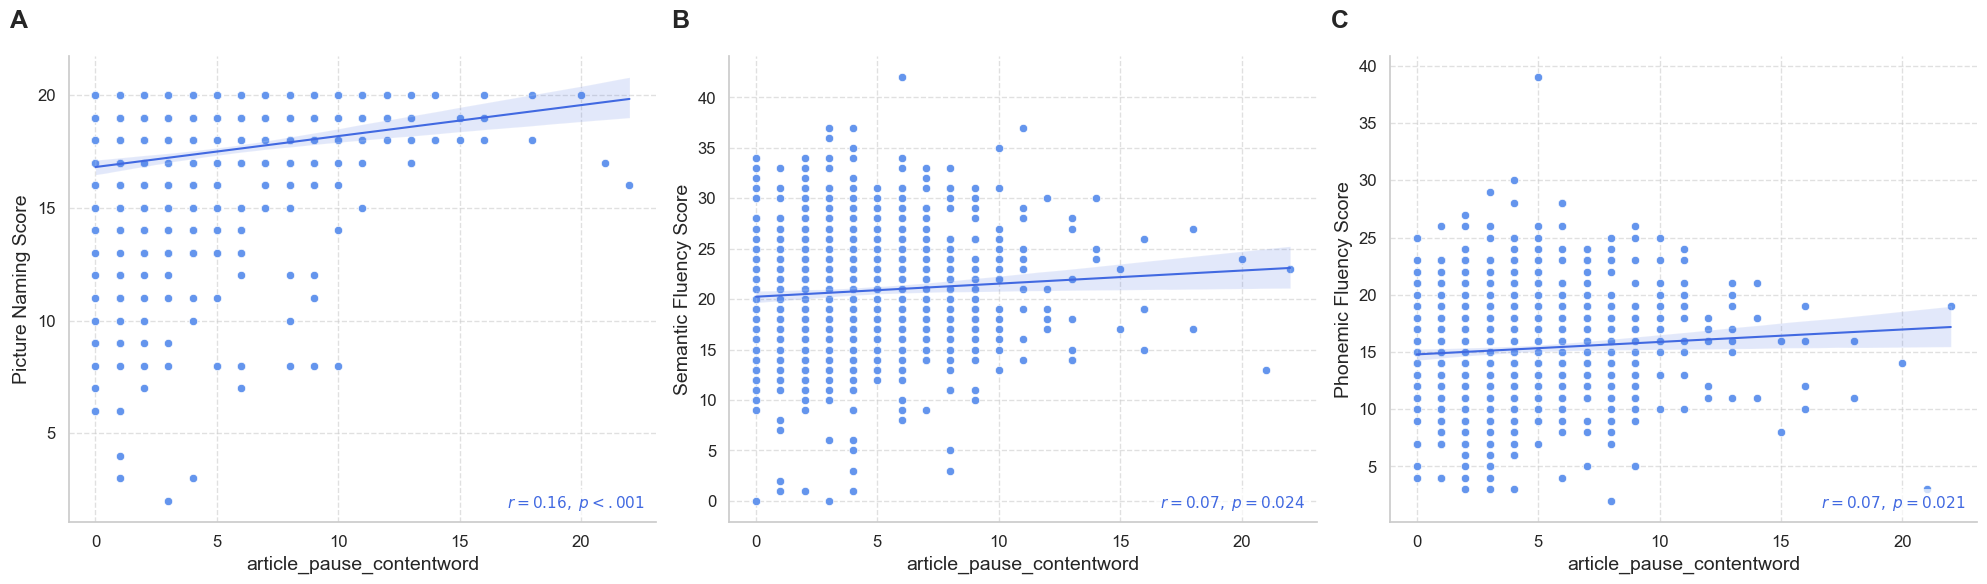

,Panel,Score,N
0,A,PictureNamingScore,985
1,B,SemanticFluencyScore,997
2,C,PhonemicFluencyScore,997


In [5]:
# setup
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import re
from scipy.stats import pearsonr
from matplotlib.ticker import MultipleLocator

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY

# define variables
task_name = "cookieTheft"
feature_name = "article_pause_contentword"
targets = ["PictureNamingScore", "SemanticFluencyScore", "PhonemicFluencyScore"]

# load data
scores_path = os.path.join(GIT_DIRECTORY, "data/language_scores_all_subjects.csv")
features_path = os.path.join(GIT_DIRECTORY, f"results/features/filtered/{task_name}_filtered.csv")
demographics_path = os.path.join(GIT_DIRECTORY, "data/demographics_data.csv")
features = pd.read_csv(features_path)
scores = pd.read_csv(scores_path)
demographics = pd.read_csv(demographics_path)

# saving dir
save_dir = os.path.join(GIT_DIRECTORY, "results", "plots", "feature_vs_target")
os.makedirs(save_dir, exist_ok=True)

# setup plot grid
fig, axes = plt.subplots(1, len(targets), figsize=(20, 6), sharex=False, sharey=False)
sns.set(style="whitegrid")

panel_labels = ["A", "B", "C"]
N_summary = []

for ax, target, label in zip(axes, targets, panel_labels):
    # merge data for this target
    df = pd.merge(features, demographics, on="Subject_ID", how="left")
    df = pd.merge(df, scores[["Subject_ID", target]], on="Subject_ID", how="left")
    df = df[[feature_name, target]].dropna()

    # correlation
    r, p = pearsonr(df[feature_name], df[target])
    p_text = "< .001" if p < 0.001 else f"= {p:.3f}"
    corr_text = rf"$r = {r:.2f},\ p {p_text}$"

    # scatter + regression line
    sns.scatterplot(data=df, x=feature_name, y=target,
                    color="cornflowerblue", ax=ax)
    sns.regplot(data=df, x=feature_name, y=target,
                scatter=False, color="royalblue", ci=95,
                line_kws={"linewidth": 1.5}, ax=ax)

    # formatting
    ax.set_xlabel(feature_name, fontsize=14)
    ax.set_ylabel(format_title(target), fontsize=14)
    ax.tick_params(axis="both", labelsize=12)
    sns.despine(ax=ax)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.yaxis.set_major_locator(MultipleLocator(5))

    # correlation text
    ax.text(
        0.98, 0.02, corr_text,
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=11, style="italic", color="royalblue",
        bbox=dict(facecolor="white", alpha=0.7,
                  edgecolor="none", boxstyle="round,pad=0.3")
    )

    N_summary.append([label, target, len(df)])


for ax, label in zip(axes, panel_labels):
    ax.text(
        -0.1, 1.05, label, transform=ax.transAxes,
        fontsize=18, fontweight="bold", va="bottom", ha="left"
    )

plt.tight_layout()
plt.savefig(os.path.join(save_dir, f"{feature_name}_all_scores_correlation_{task_name}.png"),
            dpi=300, bbox_inches="tight")
plt.show()
N_table = pd.DataFrame(N_summary, columns=["Panel", "Score", "N"])
display(N_table)